In [1]:
import qmps
import xmps
import cirq
from xmps import iMPS
import numpy as np
def ap(A, _abs = True):
    if _abs:
        print(np.around(np.abs(A), 2))
    else:
        print(np.around(A, 2))

In [5]:
from numpy.linalg import svd

def S(ρ):
    # S = Σᵢρᵢlog(ρᵢ) where ρᵢ = |λᵢ|^2 and λᵢ = singular values 
    u, s, v = svd(ρ) 
    s = np.square(np.abs(s)) 
    return np.dot(np.log2(s), s)
    

### Finding Parameterization of the 2 parameter scar mps

In [5]:
A = lambda ϕ, θ: np.array([[[0, 1j*np.exp(-1j*ϕ)], 
                            [0,0]],
                          [[np.cos(θ), 0],
                           [np.sin(θ), 0]]])

U = lambda θ, ϕ: np.array([
    [0,1j*np.exp(-1j*ϕ),0,0],
    [np.cos(θ), 0, 0, -np.sin(θ)],
    [0,0,1,0],
    [np.sin(θ), 0, 0, np.cos(θ)]
])

for x,y in zip(np.random.randn(10), np.random.randn(10)):
    assert np.allclose(U(x,y).conj().T@U(x,y), np.eye(4))

#### Exact Hamiltonian for simulation

In [34]:
import numpy as np
from numpy import kron
from functools import reduce
from scipy.linalg import expm
from qmps.represent import Tensor
def multi_tensor(Ops):
    return reduce(kron, Ops)

### Exact hamiltonian simulation for prof of principle ###
P = np.array([[0,0],[0,1]])
X = np.array([[0,1],[1,0]])
n = np.array([[1,0],[0,0]])
I = np.eye(2)

H = lambda μ:0.5*(multi_tensor([I,P,X,P]) + multi_tensor([P,X,P,I])) + (μ/4) * (multi_tensor([I,I,I,n]) + 
                                                                                multi_tensor([I,I,n,I]) +
                                                                                multi_tensor([I,n,I,I]) + 
                                                                                multi_tensor([n,I,I,I]))

W = lambda μ, dt: Tensor(expm(1j * dt * H(μ)),'H')

In [6]:
from qmps.time_evolve_tools import merge

# bUILDING THE TWO SITES FROM As

def two_site_As(θ, ϕ, θ_, ϕ_):
    A1 = A(ϕ, θ)
    A2 = A(ϕ_, θ_)
    return merge(A1,A2)

def generate_two_site_unitary(params):
    return tensor_to_unitary(two_site_As(*params))

##### Using the Direct Parametrization to build the 2-site unitary:

In [67]:
class ScarGate(cirq.Gate):
    def __init__(self, params):
        self.params = params # this order: [θ, ϕ, θ', ϕ']
        
    def num_qubits(self):
        return 3
    
    def _decompose_(self, qubits):
        q = qubits
        π = np.pi
        θ, ϕ, θ_, ϕ_ = self.params
        return [
            cirq.ZPowGate(exponent=(-1/π) * (-ϕ_ + (π/2))).on(q[2]),
            cirq.X.on(q[1]),
            cirq.CNOT(q[1], q[2]),
            cirq.X.on(q[1]),
            cirq.CNotPowGate(exponent=2*θ_/π).on(q[2], q[1]),
            cirq.S.on(q[1]),
            cirq.ZPowGate(exponent=(-1/π) * (-ϕ + (π/2))).on(q[1]),
            cirq.X.on(q[0]),
            cirq.CNOT(q[0], q[1]),
            cirq.X.on(q[0]),
            cirq.CNotPowGate(exponent=2*θ/π).on(q[1], q[0]),
            cirq.S.on(q[0])
        ]
    
u_scar = ScarGate([1,2,3,4])

q = cirq.LineQubit.range(3)
c = cirq.Circuit.from_ops([cirq.decompose_once(u_scar.on(*q))])
print(c)
        

0: ───X───────────────────────────────────────────@───X───X──────────S───
                                                  │       │
1: ───X─────────@───X───X───────────S───Z^0.137───X───────@^(7/11)───────
                │       │
2: ───Z^0.773───X───────@^(-1/11)────────────────────────────────────────


##### Trying to get the environment exactly

In [72]:
import sympy as sp
from sympy import symbols,init_printing, I
init_printing(use_latex='mathjax')

θ1, ϕ1, θ2, ϕ2 = symbols('theta_1 phi_1 theta_2 phi_2', real = True)
θ1, ϕ2

A_sp = lambda θ, ϕ: sp.Array([[[0, I*sp.exp(-I*ϕ)], 
                               [0,0]],
                               [[sp.cos(θ), 0],
                               [sp.sin(θ), 0]]])




A1 = A_sp(θ1, ϕ1)
A2 = A_sp(θ2, ϕ2)

from sympy import tensorproduct, tensorcontraction, permutedims

def merge_sp(A1, A2):
    # Merge two Bond Dim 2 Matrix Product States using Sympy
    contracted = tensorcontraction(tensorproduct(A1,A2),(2,4))
    permuted = permutedims(contracted, (0,2,1,3))
    return permuted.reshape(4,2,2)

A12 = merge_sp(A1,A2)
A12 [2,:,:] 

def transfer_matrix_sp(A12):
    # contract two 'merged' objects on their physical index, and group the remaining indices so it is a 4x4 matrix
    flipped = permutedims(A12, (0,1,2))
    flipped = flipped.conjugate()
    contracted = tensorcontraction(tensorproduct(A12, flipped),(0,3))
    grouped = permutedims(contracted,(0,2,1,3))
    return grouped.reshape(4,4).tomatrix()

tm = transfer_matrix_sp(A12)

result = tm.eigenvects()
environment = result[1][2][0].reshape(2,2)
environment

⎡                                        2                                    
⎢                                    -cos (θ₁)                                
⎢                         ────────────────────────────────                    
⎢                            2          2        2                            
⎢                         sin (θ₂) + cos (θ₁)⋅cos (θ₂) - 1                    
⎢                                                                             
⎢ ⎛⎛   2          2        2        ⎞                              3        2 
⎢-⎝⎝sin (θ₂) + cos (θ₁)⋅cos (θ₂) - 1⎠⋅sin(θ₁)⋅cos(θ₁) - sin(θ₁)⋅cos (θ₁)⋅cos (
⎢─────────────────────────────────────────────────────────────────────────────
⎢                             2          2        2                           
⎣                        - sin (θ₂) - cos (θ₁)⋅cos (θ₂) + 1                   

        ⎛⎛   2          2        2        ⎞                              3    
       -⎝⎝sin (θ₂) + cos (θ₁)⋅cos (θ₂) - 1⎠⋅sin(θ₁)

The analytical expression is not that useful since it appears too complicated to easily express with rotation gates

##### Making the Hamiltonian:

In [99]:
# How to build custom controlled gates:
# - IMPORTANT: LATER VERSIONS OF CIRQ HAVE CHANGED CONTROLLED GATE AND THIS WILL HAVE TO BE CHANGE IF WE UPDATE

q = cirq.LineQubit.range(3)
c = cirq.Circuit.from_ops(
    cirq.ControlledGate(
        sub_gate=cirq.XPowGate(),
        num_controls = 2, 
        control_qubits=[q[0], q[2]]).on(q[1])   
)


In [4]:
class PXPHamiltonian(cirq.Gate):
    def __init__(self, dt):
        self.dt = dt
    
    def num_qubits(self):
        return 4
    
    def _decompose_(self, qubits):
        q = qubits
        return[
            cirq.X.on(q[0]), cirq.X.on(q[2]),
            
            cirq.ControlledGate(
            sub_gate = cirq.XPowGate(exponent=self.dt / np.pi),
            num_controls = 2,
            control_qubits = [q[0], q[2]]).on(q[1]),
            
            cirq.X.on(q[0]), cirq.X.on(q[2]),
            
            cirq.X.on(q[1]), cirq.X.on(q[3]),

            cirq.ControlledGate(
            sub_gate = cirq.XPowGate(exponent=self.dt / np.pi),
            num_controls = 2,
            control_qubits = [q[1], q[3]]).on(q[2]),
            
            cirq.X.on(q[1]), cirq.X.on(q[3])

        ]
    
    def _circuit_diagram_info_(self, args):
        return ['H']*self.num_qubits()

    




0: ───X───@─────────X─────────────────
          │
1: ───────X─────────X───@─────────X───
          │             │
2: ───X───@^0.032───X───X─────────────
                        │
3: ───X─────────────────@^0.032───X───


In [18]:
from xmps.iMPS import Map
from qmps.time_evolve_tools import put_env_on_right_site, put_env_on_left_site
from qmps.represent import Environment 

class ScarGate(cirq.Gate):
    def __init__(self, params):
        self.params = params # this order: [θ, ϕ, θ', ϕ']

    def num_qubits(self):
        return 3

    def _decompose_(self, qubits):
        q = qubits
        π = np.pi
        θ, ϕ, θ_, ϕ_ = self.params
        return [
            cirq.ZPowGate(exponent=(-1/π) * (-ϕ_ + (π/2))).on(q[2]),
            cirq.X.on(q[1]),
            cirq.CNOT(q[1], q[2]),
            cirq.X.on(q[1]),
            cirq.CNotPowGate(exponent=2*θ_/π).on(q[2], q[1]),
            cirq.S.on(q[1]),
            cirq.ZPowGate(exponent=(-1/π) * (-ϕ + (π/2))).on(q[1]),
            cirq.X.on(q[0]),
            cirq.CNOT(q[0], q[1]),
            cirq.X.on(q[0]),
            cirq.CNotPowGate(exponent=2*θ/π).on(q[1], q[0]),
            cirq.S.on(q[0])
        ]
    
    def _circuit_diagram_info_(self, args):
        return ['U']*self.num_qubits()

A = lambda θ, ϕ: np.array([[[0, 1j*np.exp(-1j*ϕ)], 
                            [0,0]],
                           [[np.cos(θ), 0],
                            [np.sin(θ), 0]]])


ham = PXPHamiltonian(0.1)

def scars_time_evolve_cost_function(params, current_params, ham):
    '''
    params are formatted like: [θ1, ϕ1, θ2, ϕ2]
    '''    
    θ1, ϕ1, θ2, ϕ2 = current_params
    θ1_,ϕ1_,θ2_, ϕ2_ = params

    A1 = A(θ1, ϕ1)
    A2 = A(θ2, ϕ2)
    A1_= A(θ1_, ϕ1_)
    A2_= A(θ2_, ϕ2_)
    
    _, r = Map(merge(A1,A2), merge(A1_,A2_)).right_fixed_point()
    R = Environment(put_env_on_left_site(r), 'R')
    L = Environment(put_env_on_right_site(r.conj().T),'L')
    
    U12 = ScarGate(current_params)
    U12_= ScarGate(params)
    q = cirq.LineQubit.range(8)
    circuit = cirq.Circuit.from_ops([
        cirq.H(q[5]),
        cirq.CNOT(q[5],q[6]),
        U12(*q[3:6]),
        U12(*q[1:4]),
        L(*q[0:2]),
        ham(*q[2:6]),
        R(*q[6:8]),
        cirq.inverse(U12_(*q[1:4])),
        cirq.inverse(U12_(*q[3:6])),
        cirq.CNOT(q[5],q[6]),
        cirq.H(q[5])
    ])
    
    # print(circuit.to_text_diagram(transpose = True))
    sim = cirq.Simulator()
    ψ = sim.simulate(circuit).final_state[0]
    return -np.abs(ψ)*2

scars_time_evolve_cost_function(current_params, current_params, hamiltonian)

-0.9999904036521912

In [22]:
from scipy.optimize import minimize
from tqdm.notebook import tqdm
timesteps = 2000
hamiltonian = PXPHamiltonian(0.01)
current_params = [0,np.random.randn(1)[0], np.pi/2, np.random.randn(1)[0]]
final_params = []

for _ in tqdm(range(timesteps)):
    final_params.append(current_params)
    initial_params = current_params
    res = minimize(scars_time_evolve_cost_function, initial_params, args = (current_params, hamiltonian), options = {'disp':True}, method = 'Nelder-Mead')
    current_params = res.x

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 33
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 31
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 28
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 36
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 39
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 28
         Function evaluations: 90
Optimization terminated s

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 27
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 27
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 28
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 102
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 42
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 28
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 34
         Function evaluations: 98
Optimization terminated s

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 32
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 37
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 43
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 32
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 43
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 43
         Function evaluations: 113
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 32
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 48
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 34
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 37
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 23
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 37
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 29
         Function evaluations: 92
Optimization terminated

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 44
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 30
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 23
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 33
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 36
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 98
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 35
         Function evaluations: 101
Optimization terminated 

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 36
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 32
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 34
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 31
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 40
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 36
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 40
         Function evaluations: 112
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 41
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 103
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 37
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 33
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 36
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 41
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 30
         Function evaluations: 99
Optimization terminate

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 33
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 39
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 31
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 40
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 37
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 31
         Function evaluations: 97
Optimization terminat

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 27
         Function evaluations: 100
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 36
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 32
         Function evaluations: 104
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 34
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 33
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 41
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 43
         Function evaluations: 123
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 41
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 30
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 39
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 31
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 39
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 45
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 39
         Function evaluations: 126
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 35
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 36
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 43
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 37
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 32
         Function evaluations: 97
Optimization terminat

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 37
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 41
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 45
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 43
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 43
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 42
         Function evaluations: 113
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 44
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 44
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 39
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 43
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 42
         Function evaluations: 109
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 45
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 46
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 41
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 45
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 50
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 39
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 45
         Function evaluations: 115
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 35
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 33
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 52
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 49
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 34
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 45
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 45
         Function evaluations: 132
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 52
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 50
         Function evaluations: 136
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 54
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 43
         Function evaluations: 131
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 41
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 36
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 42
         Function evaluations: 126
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 36
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 42
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 34
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 35
         Function evaluations: 133
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 42
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 41
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 38
         Function evaluations: 140
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 52
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 40
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 53
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 54
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 50
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 51
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 49
         Function evaluations: 148
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 47
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 56
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 51
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 42
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 41
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 42
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 49
         Function evaluations: 148
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 59
         Function evaluations: 170
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 55
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 54
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 55
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 58
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 57
         Function evaluations: 172
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 62
         Function evaluations: 172
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 57
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 48
         Function evaluations: 161
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 51
         Function evaluations: 160
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 60
         Function evaluations: 168
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 55
         Function evaluations: 163
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 52
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 54
         Function evaluations: 163
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 50
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 56
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 56
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 56
         Function evaluations: 171
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 49
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 42
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 60
         Function evaluations: 171
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 50
         Function evaluations: 163
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 59
         Function evaluations: 175
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 64
         Function evaluations: 183
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 61
         Function evaluations: 176
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 54
         Function evaluations: 169
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 61
         Function evaluations: 187
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 57
         Function evaluations: 171
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 60
         Function evaluations: 186
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 65
         Function evaluations: 186
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 62
         Function evaluations: 182
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 66
         Function evaluations: 194
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 62
         Function evaluations: 186
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 62
         Function evaluations: 195
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 69
         Function evaluations: 205
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 53
         Function evaluations: 173
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 64
         Function evaluations: 189
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 64
         Function evaluations: 194
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 62
         Function evaluations: 187
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 65
         Function evaluations: 194
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 73
         Function evaluations: 206
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 65
         Function evaluations: 189
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 62
         Function evaluations: 207
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 70
         Function evaluations: 198
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 56
         Function evaluations: 188
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 57
         Function evaluations: 200
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 50
         Function evaluations: 188
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 52
         Function evaluations: 196
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 65
         Function evaluations: 212
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 70
         Function evaluations: 202
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 58
         Function evaluations: 187
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 70
         Function evaluations: 223
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 59
         Function evaluations: 190
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 61
         Function evaluations: 202
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 73
         Function evaluations: 212
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 64
         Function evaluations: 191
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 66
         Function evaluations: 206
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 77
         Function evaluations: 217
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 75
         Function evaluations: 212
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 76
         Function evaluations: 227
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 69
         Function evaluations: 208
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 64
         Function evaluations: 203
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 67
         Function evaluations: 203
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 75
         Function evaluations: 215
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 77
         Function evaluations: 221
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 67
         Function evaluations: 206
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 83
         Function evaluations: 228
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 74
         Function evaluations: 216
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 74
         Function evaluations: 221
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 73
         Function evaluations: 218
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 75
         Function evaluations: 230
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 69
         Function evaluations: 217
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 83
         Function evaluations: 233
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 76
         Function evaluations: 222
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 83
         Function evaluations: 238
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 80
         Function evaluations: 229
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 71
         Function evaluations: 234
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 77
         Function evaluations: 228
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 81
         Function evaluations: 240
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 83
         Function evaluations: 246
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 73
         Function evaluations: 234
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 73
         Function evaluations: 252
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 77
         Function evaluations: 237
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 84
         Function evaluations: 240
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 75
         Function evaluations: 232
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 84
         Function evaluations: 241
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 75
         Function evaluations: 239
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 72
         Function evaluations: 230
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 75
         Function evaluations: 234
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 84
         Function evaluations: 250
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 76
         Function evaluations: 240
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 83
         Function evaluations: 245
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 89
         Function evaluations: 258
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 80
         Function evaluations: 243
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 86
         Function evaluations: 258
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 85
         Function evaluations: 266
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 86
         Function evaluations: 248
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 84
         Function evaluations: 256
Optimization termina

Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 77
         Function evaluations: 246
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 87
         Function evaluations: 266
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 70
         Function evaluations: 251
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 77
         Function evaluations: 249
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 82
         Function evaluations: 249
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 92
         Function evaluations: 263
Optimization terminated successfully.
         Current function value: -0.999988
         Iterations: 88
         Function evaluations: 262
Optimization termina

## Putting it all together:

In [ ]:
#### Use this for a shallow representation of the PXP, 
#### otherwise use the W lambda function which is exact but might be really deep on chip ###

class PXPHamiltonian(cirq.Gate):
    def __init__(self, dt):
        self.dt = dt
    
    def num_qubits(self):
        return 4
    
    def _decompose_(self, qubits):
        q = qubits
        return[
            cirq.X.on(q[0]), cirq.X.on(q[2]),
            
            cirq.ControlledGate(
            sub_gate = cirq.XPowGate(exponent=self.dt / np.pi),
            num_controls = 2,
            control_qubits = [q[0], q[2]]).on(q[1]),
            
            cirq.X.on(q[0]), cirq.X.on(q[2]),
            
            cirq.X.on(q[1]), cirq.X.on(q[3]),

            cirq.ControlledGate(
            sub_gate = cirq.XPowGate(exponent=self.dt / np.pi),
            num_controls = 2,
            control_qubits = [q[1], q[3]]).on(q[2]),
            
            cirq.X.on(q[1]), cirq.X.on(q[3])

        ]
    
    def _circuit_diagram_info_(self, args):
        return ['H']*self.num_qubits()


In [142]:
import numpy as np
from numpy import kron
from functools import reduce
from scipy.linalg import expm
from qmps.represent import Tensor, Environment
from qmps.tools import tensor_to_unitary
import cirq
from qmps.time_evolve_tools import merge, put_env_on_left_site, put_env_on_right_site
from xmps.iMPS import Map
from scipy.optimize import minimize
from tqdm.notebook import tqdm 

def multi_tensor(Ops):
    return reduce(kron, Ops)

### Exact hamiltonian simulation for prof of principle ###
P = np.array([[0,0],[0,1]])
X = np.array([[0,1],[1,0]])
n = np.array([[1,0],[0,0]])
I = np.eye(2)

H = lambda μ:0.5*(multi_tensor([I,P,X,P]) + multi_tensor([P,X,P,I])) + (μ/4) * (multi_tensor([I,I,I,n]) + 
                                                                                multi_tensor([I,I,n,I]) +
                                                                                multi_tensor([I,n,I,I]) + 
                                                                                multi_tensor([n,I,I,I]))

W = lambda μ, dt: Tensor(expm(1j * dt * H(μ)),'H')

class ScarsAnsatz(cirq.Gate):
    def __init__(self, params):
        self.params = params # this order: [θ, ϕ]
        
    def num_qubits(self):
        return 2
    
    def _decompose_(self, qubits):
        q = qubits
        π = np.pi
        θ, ϕ = self.params
        return [
            cirq.ZPowGate(exponent=1/2 - ϕ/π).on(q[1]),
            cirq.X.on(q[0]),
            cirq.CNOT(q[0], q[1]),
            cirq.X.on(q[0]),
            cirq.CNotPowGate(exponent=2*θ/π).on(q[1], q[0]),  # global_shift is needed to remove erronous complex numbers
            cirq.S.on(q[0]),
            cirq.ZPowGate(exponent=-θ/π).on(q[1])
        ]

class ScarGate(cirq.Gate):
    def __init__(self, params):
        self.params = params # this order: [θ, ϕ, ϕ', θ']

    def num_qubits(self):
        return 3

    def _decompose_(self, qubits):
        q = qubits
        π = np.pi
        θ, ϕ, ϕ_, θ_ = self.params
        return [
            ScarsAnsatz([θ_, ϕ_]).on(*q[1:3]),
            ScarsAnsatz([θ, ϕ]).on(*q[0:2])
        ]
    
    def _circuit_diagram_info_(self, args):
        return ['U']*self.num_qubits()

A = lambda θ, ϕ: np.array([[[0, 1j*np.exp(-1j*ϕ)], 
                            [0,0]],
                           [[np.cos(θ), 0],
                            [np.sin(θ), 0]]])


def scars_time_evolve_cost_function(params, current_params, ham):
    '''
    params are formatted like: [θ1, ϕ1, ϕ2, θ2], for convenience with the classical differential eqn solver
    '''    
    θ1, ϕ1, ϕ2, θ2 = current_params
    θ1_, ϕ1_, ϕ2_, θ2_ = params

    A1 = A(θ1, ϕ1)
    A2 = A(θ2, ϕ2)
    A1_= A(θ1_, ϕ1_)
    A2_= A(θ2_, ϕ2_)
    
    _, r = Map(merge(A1,A2), merge(A1_,A2_)).right_fixed_point()
    R = Environment(put_env_on_left_site(r), 'R')
    L = Environment(put_env_on_right_site(r.conj().T),'L')
    
    U12 = ScarGate(current_params)
    U12_= ScarGate(params)
    q = cirq.LineQubit.range(8)
    circuit = cirq.Circuit.from_ops([
        cirq.H(q[5]),
        cirq.CNOT(q[5],q[6]),
        U12(*q[3:6]),
        U12(*q[1:4]),
        L(*q[0:2]),
        ham(*q[2:6]),
        R(*q[6:8]),
        cirq.inverse(U12_(*q[1:4])),
        cirq.inverse(U12_(*q[3:6])),
        cirq.CNOT(q[5],q[6]),
        cirq.H(q[5])
    ])
    
    # print(circuit.to_text_diagram(transpose = True))
    sim = cirq.Simulator()
    ψ = sim.simulate(circuit).final_state[0]
    return -np.abs(ψ)*2

def scars_cost_fun_alternate(params, current_params, ham):
    '''
    This cost function doesn't use the quantum circuit parameterisation
    
    params are formatted like: [θ1, ϕ1, ϕ2, θ2], for convenience with the classical differential eqn solver
    '''    
    θ1, ϕ1, ϕ2, θ2 = current_params
    θ1_, ϕ1_, ϕ2_, θ2_ = params

    A1 = A(θ1, ϕ1)
    A2 = A(θ2, ϕ2)
    A1_= A(θ1_, ϕ1_)
    A2_= A(θ2_, ϕ2_)
    
    A12 = merge(A1,A2)
    A12_= merge(A1_,A2_)
    
    _, r = Map(A12, A12_).right_fixed_point()
    R = Environment(put_env_on_left_site(r), 'R')
    L = Environment(put_env_on_right_site(r.conj().T),'L')
    
    U12 = Tensor(tensor_to_unitary(A12),'U')
    U12_= Tensor(tensor_to_unitary(A12_),'U\'')
    
    q = cirq.LineQubit.range(8)
    circuit = cirq.Circuit.from_ops([
        cirq.H(q[5]),
        cirq.CNOT(q[5],q[6]),
        U12(*q[3:6]),
        U12(*q[1:4]),
        L(*q[0:2]),
        ham(*q[2:6]),
        R(*q[6:8]),
        cirq.inverse(U12_(*q[1:4])),
        cirq.inverse(U12_(*q[3:6])),
        cirq.CNOT(q[5],q[6]),
        cirq.H(q[5])
    ])
    
    # print(circuit.to_text_diagram(transpose = True))
    sim = cirq.Simulator()
    ψ = sim.simulate(circuit).final_state[0]
    return -np.abs(ψ)*2

def simulate_scars(dt, timesteps, μ, initial_params, save_file = None):
    hamiltonian = W(μ, dt)
    final_params = []
    current_params = initial_params
    for _ in tqdm(range(timesteps)):
        final_params.append(np.mod(current_params, 2*np.pi))
        res = minimize(scars_time_evolve_cost_function, current_params, args = (current_params, hamiltonian), options = {'disp':True}, method = 'Nelder-Mead')
        current_params = res.x
    
    if save_file:
        np.save(save_file, np.array(final_params))
    
    return np.array(final_params)
    

#### ODE Analytical Solver:

In [1]:
# Using tensor_to_unitary we almost exactly recreate the exact TDVP differential equation solutions.
from tqdm.notebook import tqdm
import tqdm
from numpy import sin, cos, tan, arcsin, pi
import numpy as np
from scipy.integrate import odeint
from joblib import Parallel, delayed
from multiprocessing import cpu_count

dθdt = lambda θ1, ϕ1, ϕ2, θ2: tan(θ2)*sin(θ1)*(cos(θ1)**2)*cos(ϕ1) + cos(θ2)*cos(ϕ2)
dϕdt = lambda θ1, ϕ1, ϕ2, θ2: 2*tan(θ1)*cos(θ2)*sin(ϕ2) - 0.5*tan(θ2)*cos(θ1)*sin(ϕ1)*(2*(sin(θ2)**-2) + 
                                                                                                cos(2*θ1) - 5)

def func_list(angles,t,μ):
    return[dθdt(*angles), -μ + dϕdt(*angles), -μ + dϕdt(*reversed(angles)), dθdt(*reversed(angles))]

np.random.seed(0)

y0 = np.random.randn(4)
steps = 10000
t = np.linspace(0.0, 500, steps)
dt = 4 * t[1]-t[0]
μ = 0.325

# msp =np.empty([1,4]) # multiple-starting-points
# for _ in tqdm(range(100)):
#     y0 = np.random.uniform(low = 0, high = 2*np.pi, size = 4)
#     classical_angles = np.mod(odeint(func_list, y0, t, args=(μ,)), np.pi * 2)
#     msp = np.concatenate((msp, classical_angles), axis = 0)

def process_values(init_angles, params):
    y0 = init_angles
    func_list, t, μ = params
    return np.mod(odeint(func_list, y0, t, args=(μ,)), np.pi * 2)

parameters = [func_list, t, μ]

# start initial angles on a grid of points 
θ2_grid = np.linspace(2.91, 3.05, 10)
ϕ2_grid = np.linspace(0, 0.5, 10)
grid = np.array(np.meshgrid(θ2_grid,ϕ2_grid, ϕ2_grid, θ2_grid))
reshaped = grid.reshape(4,10000)
final_grid = [[θ1, ϕ1, ϕ2, θ2] for θ1,ϕ1,ϕ2,θ2 in reshaped.T]

#random_init_angles = tqdm.tqdm([np.random.uniform(low = 0, high = np.pi * 2, size  = 4) for i in range(500)])
processed_list = Parallel(n_jobs=-1)(delayed(process_values)(i, parameters) for i in tqdm.tqdm(final_grid))
    
    
# quantum_angles = simulate_scars(dt, steps, μ, y0, save_file=f'{steps}_{dt}_{μ}_random_initial')
# file = f'{steps}_{dt}_{μ}_random_initial.npy'
# quantum_angles = np.load(file)


100%|██████████| 10000/10000 [4:53:00<00:00,  1.76s/it] 


In [5]:
len(processed_list[0])

10000

In [72]:
arr = np.array(processed_list)
arr = arr.reshape(400*10000, 4)
processed_list

[array([[2.80000000e+00, 0.00000000e+00, 0.00000000e+00, 1.57079633e+00],
        [3.14242608e+00, 6.27505272e+00, 6.28318531e+00, 1.52079190e+00],
        [3.14492549e+00, 6.26687931e+00, 3.86051920e-09, 1.47079156e+00],
        ...,
        [3.61310177e+00, 3.40689924e+00, 3.03482501e+00, 4.52784082e-01],
        [3.57751277e+00, 3.38025604e+00, 3.02258501e+00, 4.87596168e-01],
        [3.54326418e+00, 3.35694533e+00, 3.00835377e+00, 5.23929032e-01]]),
 array([[2.81578947e+00, 0.00000000e+00, 0.00000000e+00, 1.57079633e+00],
        [3.14242608e+00, 6.27505271e+00, 6.28318529e+00, 1.52079190e+00],
        [3.14492550e+00, 6.26687932e+00, 1.25386228e-09, 1.47079153e+00],
        ...,
        [4.28422235e+00, 4.59670732e+00, 3.11847863e+00, 2.68969854e-01],
        [4.23623817e+00, 4.51371706e+00, 3.11561974e+00, 2.47802938e-01],
        [4.18828630e+00, 4.41734378e+00, 3.11258668e+00, 2.33116247e-01]]),
 array([[2.83157895e+00, 0.00000000e+00, 0.00000000e+00, 1.57079633e+00],
        

In [8]:
len(processed_list)

1000

<IPython.core.display.Javascript object>


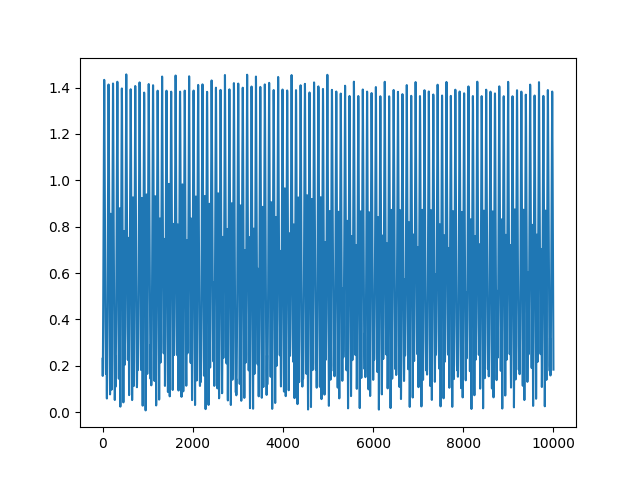

<IPython.core.display.Javascript object>


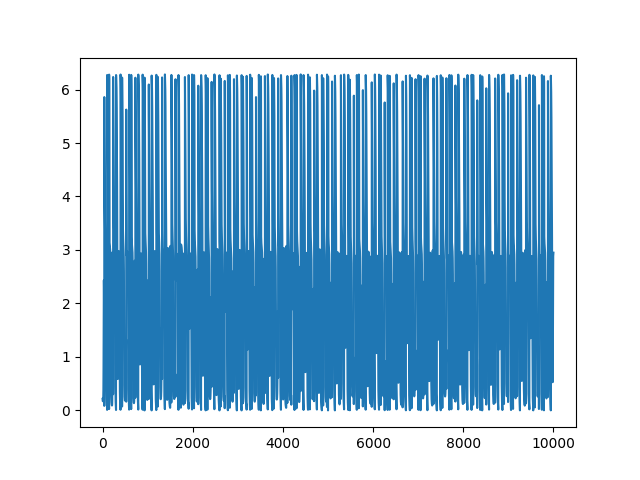

<IPython.core.display.Javascript object>


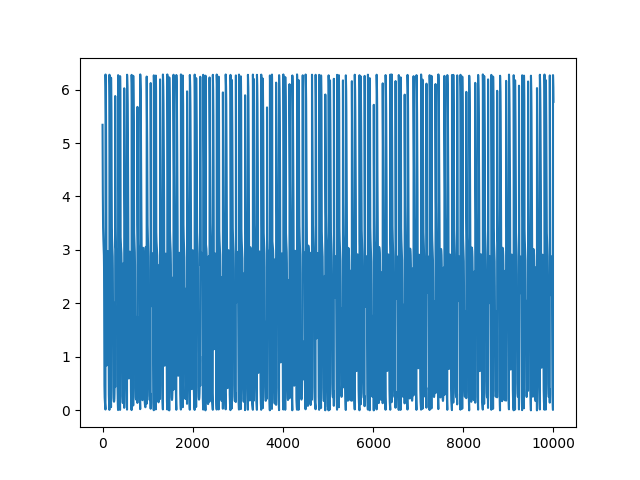

<IPython.core.display.Javascript object>


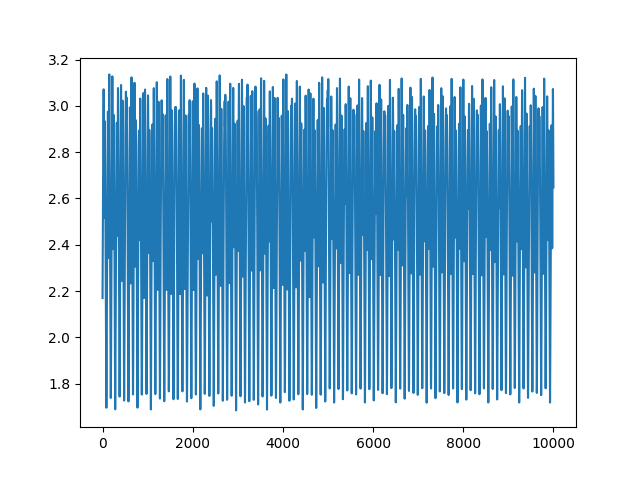

In [5]:


for i in range(4):
    plt.figure()
    plt.plot(arr[25000:35000,i])
    plt.show()

<IPython.core.display.Javascript object>


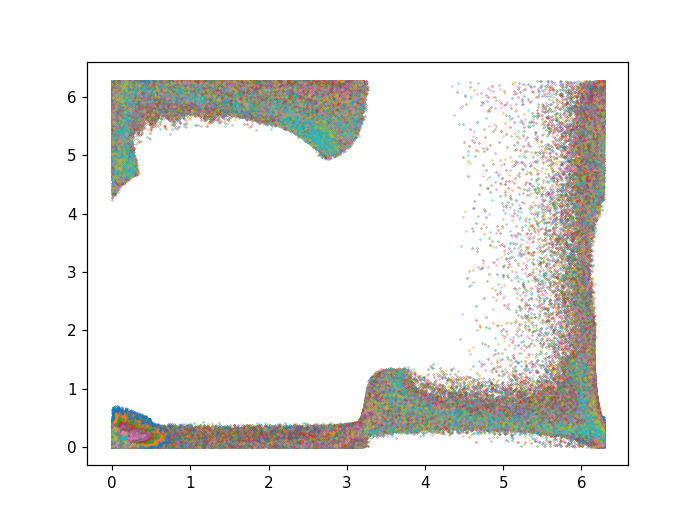

In [9]:
def crosses_slice(array, index, value, direction):
    result = []
    for i, row in enumerate(array):
        if i > 0:
            if direction == '+ve':
                condition_satisfied = (array[i-1,index] < value) & (row[index] > value)
            elif direction == '-ve':
                condition_satisfied = (array[i-1,index] > value) & (row[index] < value)
                
            if condition_satisfied:
                result.append(row)
    
    return np.array(result)
%matplotlib notebook
import matplotlib.pyplot as plt

plt.figure()
for arr in processed_list:
    poincare_map = crosses_slice(arr, 0, 2.9, '-ve')
    x = poincare_map[:,1]
    y = poincare_map[:,2]
    plt.scatter(x,y, s=0.1)

plt.show()